In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
# produce V1_allpos, V1_feature, V1_RF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import integrate
from scipy.stats import qmc
from patch_square import *
#fdr = 'D:/scratch/patchV1/resource/'
#fdr = 'C:/Users/gueux/Repos/patchV1/Data/'
# fdr = '/root/autodl-tmp/public/resource/'
fdr = '/root/autodl-tmp/ljy/resource_onlyLGN_sf20_new/'
seed = 6532787
rng = np.random.default_rng(seed = seed)

In [2]:
ecc0 = 2
deg2_per_mm2 = ecc0*ecc0*np.pi/(217.364/2) # halved for single eye condition (ocular dominance columns for ipsi and contra are mostly balanced)
print(f'average areal CMF within 2 degree eccentricity  = {deg2_per_mm2:.3f} deg2/mm2')
# total V1 area 840mm2 O\'Kusky Colonnier 1982
# 2.0 ecc yields 217.364 𝑚𝑚2 ~ 0.11562 deg2 per mm2
# L2/3 model density ~ 14766.156 per 𝑚𝑚2 (18)
# L4Cbeta model density ~ 24613.409 per 𝑚𝑚2 (30)
# L4Calpha model density ~ 14193.732 per mm2 (17.3)

#    4Cbeta  4Calpha L2/3
# #   480      272    272 = 1024
# E/I 4:1      3:1    3:1  
#              E              I
# block: 384, 204, 204 | 96, 68, 68

# using uniform density
theme = 'minimal-patch'
#den_L2_3 = 46020.984
den_L4beta = 24613.409
#den_L4alpha = 14193.732
#den = np.array([den_L2_3, den_L4beta, den_L4alpha])
den = den_L4beta
theme = '_'+theme

nOP = 1
r0 = 0.25
pos_range = np.array([-r0, r0])
area = np.pi*r0*r0

deg0 = np.sqrt(deg2_per_mm2)*r0
print(f' {r0} mm ~ {deg0:.3f} deg with averaged CMF within 2 degree ')
# foveal Dow et. al., 1985  w = 7.7 ln(x + iy + 0.33)

dow_mm2deg = lambda x: np.exp(x/7.7) - 0.33
int_dow_mm2deg = lambda x: 7.7*np.exp(x/7.7) - 0.33*x - 7.7
foveal_dow_mm_per_min = lambda x: 1/(2.421 + 0.116*x) # min
int_foveal_dow_mm2deg = lambda x: (20.8713*np.exp(0.116*x) - 20.87069)/60 # mm
foveal_dow_mm2deg = lambda x: (2.421 * np.exp(0.116*x))/60

deg1 = int_dow_mm2deg(r0)
deg2 = int_foveal_dow_mm2deg(r0)
print(f'Dow et. al., 1985 integration through linear CMF: {r0} mm ~ {deg1:.5f} deg')
# Dow et. al., 1981
print(f'Dow et. al., 1981 integration through inversed foveal linear CMF: {r0} mm ~ {deg2:.5f} deg')

ecc = deg2
print(f'ecc = {ecc}')
print(f'area = {area:.3f} mm2, visual area = {ecc*ecc*np.pi:.3e} deg2')
warpSize = 32

average areal CMF within 2 degree eccentricity  = 0.116 deg2/mm2
 0.25 mm ~ 0.085 deg with averaged CMF within 2 degree 
Dow et. al., 1985 integration through linear CMF: 0.25 mm ~ 0.17160 deg
Dow et. al., 1981 integration through inversed foveal linear CMF: 0.25 mm ~ 0.01025 deg
ecc = 0.01024565897781334
area = 0.196 mm2, visual area = 3.298e-04 deg2


In [3]:
nV1 = int(np.round(den*area/warpSize))*warpSize
nV1_32 = nV1//warpSize
min_residual = np.inf
for i in range(2, nV1_32):
    nWarpPerBlock = int(np.round(nV1_32/i))
    residual = abs(nV1_32 - nWarpPerBlock*i)
    if nWarpPerBlock <= 32 and residual < min_residual:
        min_residual = residual
        nblock = i
        blockSize = nWarpPerBlock*warpSize

print(f'putative nV1 = {nV1}')        
blockSize = 1024
nV1 = nblock*blockSize
print(f'blockified to {nV1}: {nblock}x{blockSize}')
blockArea = area/nblock
#print(blockArea)
def get_chord_ratio(r0, r1, n):
    return 2*np.pi*r1/n/(r1-r0)

min_var = np.inf
for nr in range(max([int(np.floor(r0/np.sqrt(blockArea))*0.5), 1]), min([int(np.ceil(r0/np.sqrt(blockArea))*1.5), nblock])):
    dr = r0/nr
    ra = np.array([np.pi*dr*dr*((i+1)*(i+1) - i*i) for i in range(nr)])
    residual = np.round(ra/blockArea) - ra/blockArea
    iblock = np.round(ra/blockArea).astype(int)
    rblock = sum(iblock) - nblock
    #print(f'nr = {nr}, residual block = {rblock}')
    isort = np.argsort(residual)
    if rblock > 0:
        j = 0
        iblock[isort[nr-1-j]] -= 1
        rblock -= 1
        while (rblock > 0):
            iblock[isort[nr-1-j]] -= 1
            rblock -= 1
            j += 1
    if rblock < 0:
        j = 0
        iblock[isort[j]] += 1
        rblock += 1
        while (rblock < 0):
            iblock[isort[j]] += 1
            rblock += 1
            j += 1
    assert(sum(iblock) == nblock)
    rr = np.zeros(nr)
    inner_r = 0
    inner_area = iblock[0] * blockArea

    for ir in range(nr):
        rr[ir] = np.sqrt(inner_area/np.pi) - inner_r
        inner_r += rr[ir]
        if ir < nr-1:
            inner_area += iblock[ir+1] * blockArea
    var_r = np.mean(np.power(rr - dr,2))
    if var_r < min_var:
        ring_r = rr
        ring_block = iblock

nring = ring_r.size
print(f'#ring: {nring}, r0 = {r0}')
print(ring_r)
print(ring_block)

putative nV1 = 4832
blockified to 5120: 5x1024
#ring: 2, r0 = 0.25
[0.1118034 0.1381966]
[1 4]


In [4]:
nE = 768

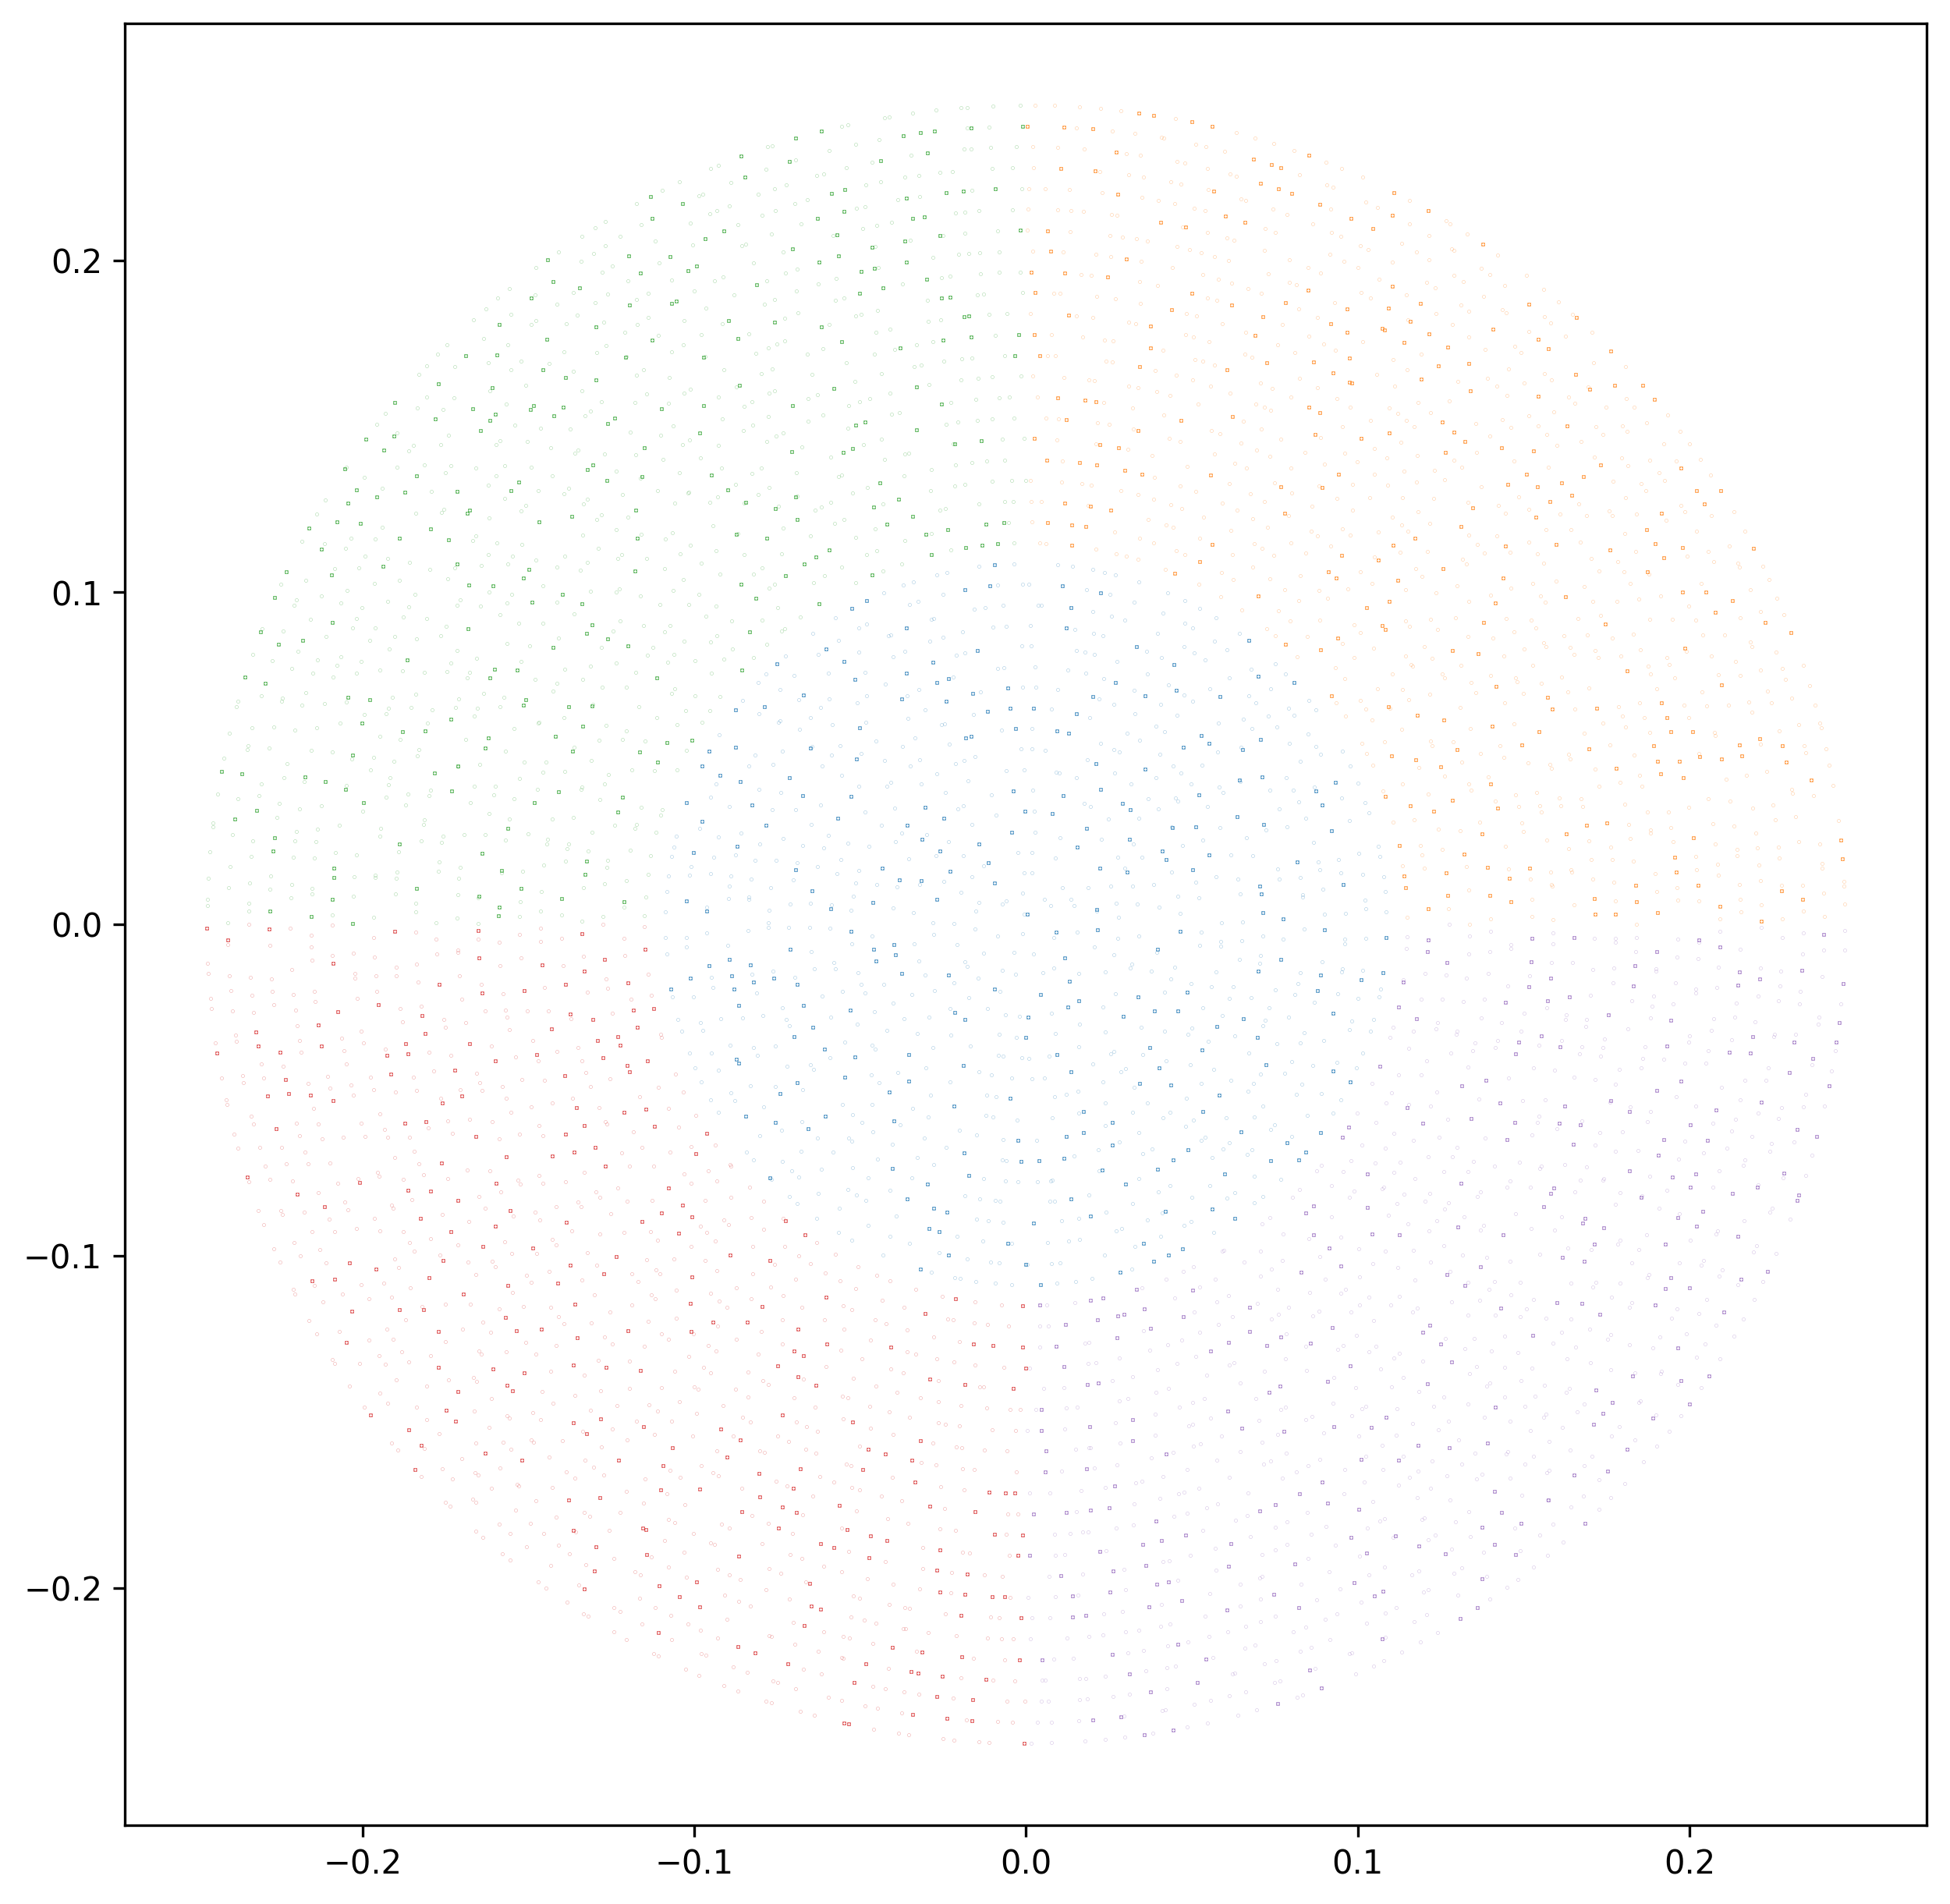

In [5]:
pos_filename = fdr + 'V1_allpos'+theme+'.bin'
fig = plt.figure(figsize = [10, 10], dpi = 300)
ax = fig.add_subplot(111)
fpos = np.empty((2,nV1), dtype = 'f8')
OP = np.empty(nV1, dtype = 'f4')
LR = np.zeros(nV1, dtype = 'f4') - 1
d = np.sqrt(blockArea/blockSize)
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize], dtype = 'u4').tofile(f)
    r_offset = 0
    block_offset = 0
    for i in range(nring):
        nl = int(np.round(ring_r[i]/d))
        n = np.array([np.pi/ring_block[i]*(np.power(r_offset + (x+1)/nl*ring_r[i], 2) - np.power(r_offset + x/nl*ring_r[i], 2))/blockArea * blockSize for x in range(nl)])
        assert(np.round(sum(n)) == blockSize)
        residual = np.round(n) - n
        n = np.round(n).astype(int)
        rn = sum(n) - blockSize
        isort = np.argsort(residual)
        if rn > 0:
            j = 0
            n[isort[nl-1-j]] -= 1
            rn -= 1
            while (rn > 0):
                n[isort[nl-1-j]] -= 1
                rn -= 1
                j += 1
        if rn < 0:
            j = 0
            n[isort[j]] += 1
            rn += 1
            while (rn < 0):
                n[isort[j]] += 1
                rn += 1
                j += 1
        assert(sum(n) == blockSize)
        for j in range(ring_block[i]):  
            n0 = 0
            polar = np.empty((blockSize,2))
            for k in range(nl):
                sampler = qmc.Sobol(d = 1)
                sample = sampler.random(n = n[k])
                #polar[n0:n0 + n[k],:] = qmc.scale(sample, [j/ring_block[i]*2*np.pi, r_offset], [(j+1)/ring_block[i]*2*np.pi, r_offset + (k+1)/nl*ring_r[i]])
                polar[n0:n0 + n[k], 0] = qmc.scale(sample, j/ring_block[i]*2*np.pi, (j+1)/ring_block[i]*2*np.pi).T
                polar[n0:n0 + n[k], 1] = r_offset + (k+0.5)/nl*ring_r[i]
                n0 += n[k]
            idx = rng.permutation(np.arange(blockSize))
            x_pos = polar[idx,1] * np.cos(polar[idx,0])
            y_pos = polar[idx,1] * np.sin(polar[idx,0])
            OP[(block_offset + j)*blockSize:(block_offset + j + 1)*blockSize] = polar[idx,0]/(2*np.pi)
            fpos[0, (block_offset + j)*blockSize:(block_offset + j + 1)*blockSize] = x_pos
            fpos[1, (block_offset + j)*blockSize:(block_offset + j + 1)*blockSize] = y_pos
            line = ax.plot(x_pos[:nE], y_pos[:nE], 'o', ms = 0.05)
            ax.plot(x_pos[nE:], y_pos[nE:], 's', color = line[0].get_color(), ms = 0.05)
        r_offset += ring_r[i]
        block_offset += ring_block[i]
    fpos.tofile(f)

    vpos = (fpos - pos_range[0])/(pos_range[1]-pos_range[0])*2*ecc-ecc
    vpos.astype('f8').tofile(f)
ax.set_aspect('equal')

In [6]:
# old
pos_filename = fdr + 'V1_allpos'+theme+'.bin'
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize], dtype = 'u4').tofile(f)
    np.array([2]).astype('u4').tofile(f)
    span = np.array([pos_range[0], pos_range[1]-pos_range[0], pos_range[0], pos_range[1]-pos_range[0]])
    span.tofile(f)
    fpos.tofile(f)
    vspan = np.array([-ecc, 2*ecc, -ecc, 2*ecc])
    vspan.tofile(f)
    vpos.tofile(f)
    print(vspan)
    print(vpos[0,:].min(), vpos[0,:].max())
    print(vpos[1,:].min(), vpos[1,:].max())

[-0.01024566  0.02049132 -0.01024566  0.02049132]
-0.010116802308647067 0.010116643915100568
-0.010116904356141342 0.010116686673553045


In [7]:
# old
vpos_filename = fdr + 'V1_vpos'+theme+'.bin'
n = vpos.shape[1]
V1_vpos = np.empty((2,n),dtype ='f8')
V1_vpos[0,:] = np.sqrt(vpos[0,:]*vpos[0,:] + vpos[1,:]*vpos[1,:])
V1_vpos[1,:] = np.arctan2(vpos[1,:], vpos[0,:])
with open(vpos_filename, 'wb') as f:
    np.array([n]).astype('u4').tofile(f)
    V1_vpos.tofile(f)

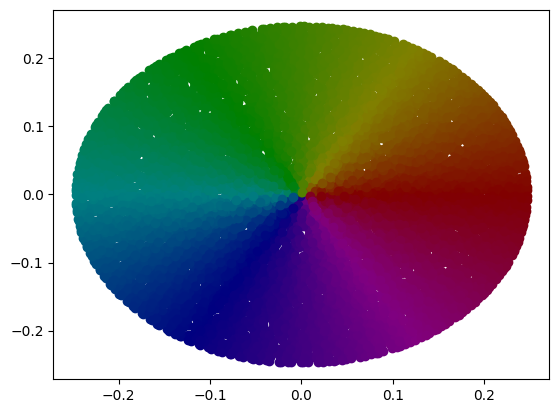

In [8]:
fig = plt.figure()
hsv = np.zeros((nV1,3))
hsv[:, 0] = OP
hsv[:, 1] = 1.0
hsv[:, 2] = 0.5
ax = fig.add_subplot(111)
for i in range(nV1):
    ax.plot(fpos[0,i], fpos[1,i], 'o', color = clr.hsv_to_rgb(hsv[i,:]))

In [9]:
feature_filename = fdr+'V1_feature'+theme+'.bin'
with open(feature_filename, 'wb') as f:
    nFeature = 2
    np.array([nFeature], dtype = 'u4').tofile(f)
    ## feature1: OD
    #nfl = 3 # V1 layers that have this feature, 0: L2/3, 1:L4-beta, 2:L4-alpha
    #np.array([nfl, 0, 1, 2], dtype = 'u4').tofile(f)
    #nV1.astype('u4').tofile(f)
    LR.astype('f4').tofile(f)
    #LR[1].astype('f4').tofile(f)
    #LR[2].astype('f4').tofile(f)
    ## feature2: OP
    #nfl = 3 # V1 layers that have this feature, 0: L2/3, 1:L4-beta, 2:L4-alpha
    #np.array([nfl, 0, 1, 2], dtype = 'u4').tofile(f) 
    #nV1.astype('u4').tofile(f)
    OP.astype('f4').tofile(f)
    #OP[1].astype('f4').tofile(f)
    #OP[2].astype('f4').tofile(f)
#for i in range(3):
#    print(np.min(LR[i]), np.max(LR[i]))
#    print(np.min(OP[i]), np.max(OP[i]))

In [10]:
# Excluding S_on, S_off from LGN Koniocellular layers to L1, L2/3 for now
# everybody use Clark 41' data
neye = 1
#ratio = 0.75  # 25% interneuron, but Clark 41' Nissl stained the neurons, states only one morphological population is found
ratio = 3
LGN_RF_ratio = 0.125 # 11.55 cones wide for foveal V1 RF, 5 cones for LGN
dow_RFsize_ecc = lambda E:13.32*E + 0.0116  # Dow et. al., 1981
LGN_RF_extent = 0.5*dow_RFsize_ecc(ecc*60)/60 * np.sqrt(LGN_RF_ratio)
LGN_ecc = ecc + LGN_RF_extent
# Malpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798) # cells/deg^2
parvo_slice = lambda E: np.pi*E*parvo_den_alt(E)
result = integrate.quad(parvo_slice, 0, LGN_ecc)
nparvo = round(result[0]*(3-neye)*ratio)
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012) # cells/deg^2
magno_slice = lambda E: np.pi*E*magno_den_alt(E)
result = integrate.quad(magno_slice, 0, LGN_ecc)
nmagno = round(result[0]*(3-neye)*ratio)

# nparvo per volume from Azzopardi et. al., 1999, layer thickness ~1/7mm from O'Kusky & Colonnier 1982
nparvo_per_4Cbeta = 17500/7 # per mm2 at ecc = 0
nmagno_per_4Calpha = 1000/7
nparvo0 = int(nparvo_per_4Cbeta * area)

# from Van Essen & Connolly 1984

parvo_den_vanEssen = lambda E: 26800*np.power(0.8 + E, -1.86) + 6470*np.power(1.01 + E, -1.5) # cells/deg^2
parvo_slice = lambda E: np.pi*E*parvo_den_vanEssen(E)
result = integrate.quad(parvo_slice, 0, LGN_ecc)
nparvo1 = round(result[0]*(3-neye)*ratio) # two-eye half disk to one-eye full disk
print(nparvo, nparvo0, nparvo1)

nparvo = nparvo1

nparvo = ((nparvo + warpSize-1)//warpSize)*warpSize
nmagno = ((nmagno + warpSize-1)//warpSize)*warpSize
print(nparvo, nmagno)
# C-On:Off ~ 3:1; (Wiesel and Hubel 1966) cone-to-ganglion ~ 1:1 (McMahon et al., 2000)
# Red:Green (L:M), 1.5-2.0 overall, very large variations(Deeb et al., 2000, Bowmaker et. al., 2003)
rL_on = 0 # 6
rL_off = 1 # 2
rM_on = 2 # 3
rM_off = 3 # 1
nparvo_warp = nparvo//warpSize
nmagno_warp = nmagno//warpSize
nparvo = nparvo_warp * warpSize
nmagno = nmagno_warp * warpSize
print(f'{nparvo} parvo cells, {nmagno} magno cells')
RG_OnOff = np.zeros(nparvo)
i = 0
RG_OnOff[i:i+nparvo//4] = rL_on
i += nparvo//4
RG_OnOff[i:i+nparvo//4] = rL_off
i += nparvo//4
n_Lcone = i
RG_OnOff[i:i+nparvo//4] = rM_on
i += nparvo//4
RG_OnOff[i:i+nparvo//4] = rM_off
i += nparvo//4
n_Mcone = i - n_Lcone
assert(i==nparvo)
OnOff = np.zeros(nmagno)
i = 0
OnOff[i:i+nmagno//2] = 4
i += nmagno//2
OnOff[i:i+nmagno//2] = 5
i += nmagno//2
assert(i==nmagno)
print(f'nV1: {nV1} nparvo: {nparvo}')
print(f'n_Mcone = {n_Mcone}, n_Lcone = {n_Lcone}')
print(f'LGN_ecc = {LGN_ecc}')

629 490 498
512 32
512 parvo cells, 32 magno cells
nV1: 5120 nparvo: 512
n_Mcone = 256, n_Lcone = 256
LGN_ecc = 0.034404936358889714


In [11]:
def sobol_disk_pos(ecc, n):
    sampler = qmc.Sobol(d = 2)
    m = int(np.ceil(4*n/np.pi))
    sample = sampler.random(n = m)
    _pos = qmc.scale(sample, [- ecc, -ecc], [ecc, ecc]).T
    r = np.linalg.norm(_pos, axis = 0)
    pos = _pos[:, r < ecc]
    if pos.shape[1] < n:
        print(f'short of {n - pos.shape[1]} LGN cells')
        _ecc = ecc / np.sqrt(2)
        _sample = sampler.random(n = n-pos.shape[1])
        _pos = qmc.scale(_sample, [-_ecc, -_ecc], [_ecc, _ecc]).T
        print(_pos.shape)
        print(pos.shape)
        cart = np.hstack((pos, _pos))
    else:
        cart = pos[:, :n]
    return cart

def poisson_disk_pos(ecc, n, ratio, seed):    
    m = int(np.ceil(4*n/np.pi))
    _radius = ratio/np.sqrt(m)
    print(f'#candidates = {m}, radius = {_radius:.2f}, seed = {seed}')
    engine = qmc.PoissonDisk(d=2, radius = _radius, ncandidates = m, seed = seed)
    #sample = engine.random(n = m).T
    sample = engine.fill_space().T
    _pos = (sample - 0.5)*2*ecc
    r = np.linalg.norm(_pos, axis = 0)
    pos = _pos[:, r < ecc]
    if pos.shape[1] < n:
        print(f'short of {n - pos.shape[1]} LGN cells')
        while pos.shape[1] < n:
            m = int(np.ceil(4*(n-pos.shape[1])/np.pi))
            #sample = engine.random(n = m).T
            sample = engine.fill_space().T
            _pos = (sample - 0.5)*2*ecc
            r = np.linalg.norm(_pos, axis = 0)
            _pos = _pos[:, r < ecc]
            pos = np.hstack((pos, _pos))

        cart = pos
    if pos.shape[1] > n:
        print(f'exceeds {pos.shape[1] - n} LGN cells')
        idx = np.random.permutation(np.arange(pos.shape[1]))
        cart = pos[:,idx[:n]]
    else:
        cart = pos
    return cart


def poisson_disk_pos0(ecc, n, ratio, seed):    
    m = int(np.ceil(4*n/np.pi))
    _radius = ratio/np.sqrt(m)
    print(f'#candidates = {m}, radius = {_radius:.2f}, seed = {seed}')
    engine = qmc.PoissonDisk(d=2, radius = _radius, ncandidates = m, seed = seed)
    #sample = engine.random(n = m).T
    sample = engine.fill_space().T
    seed += 1
    _pos = (sample - 0.5)*2*ecc
    r = np.linalg.norm(_pos, axis = 0)
    pos = _pos[:, r < ecc]
    count = 0
    
    while pos.shape[1] != n and count < 100:
        if pos.shape[1] < n:
            print(f'short of {n - pos.shape[1]} LGN cells')
        else:
            print(f'extra {pos.shape[1] - n} LGN cells')
        # m = int(np.ceil(4*(n-pos.shape[1])/np.pi))
        # sample = engine.random(n = m).T
        engine = qmc.PoissonDisk(d=2, radius = _radius, ncandidates = m, seed = seed)
        sample = engine.fill_space().T
        seed += 1
        _pos = (sample - 0.5)*2*ecc
        r = np.linalg.norm(_pos, axis = 0)
        pos = _pos[:, r < ecc]
        count += 1
    if count == 100:
        raise Exception('exceeds trial count')
    cart = pos.copy()
    return cart, seed
    

In [12]:
parvo_cart = np.empty((2,nparvo), dtype = 'f8')
seed = 437582
density = 0.82
#parvo_cart[:,:n_Lcone//2] = sobol_disk_pos(LGN_ecc, n_Lcone//2)
parvo_cart[:,:n_Lcone//2], seed = poisson_disk_pos0(LGN_ecc, n_Lcone//2, density, seed)
parvo_cart[:,n_Lcone//2:n_Lcone] = parvo_cart[:,:n_Lcone//2]

#parvo_cart[:,n_Lcone:n_Lcone + n_Mcone//2] = sobol_disk_pos(LGN_ecc, n_Mcone//2)
parvo_cart[:,n_Lcone:n_Lcone + n_Mcone//2], seed = poisson_disk_pos0(LGN_ecc, n_Mcone//2, density, seed)
parvo_cart[:,n_Lcone + n_Mcone//2:] = parvo_cart[:,n_Lcone:n_Lcone + n_Mcone//2]

#candidates = 163, radius = 0.06, seed = 437582
extra 1 LGN cells
short of 1 LGN cells
short of 3 LGN cells
short of 5 LGN cells
short of 7 LGN cells
short of 6 LGN cells
short of 7 LGN cells
short of 3 LGN cells
short of 4 LGN cells
short of 7 LGN cells
short of 3 LGN cells
#candidates = 163, radius = 0.06, seed = 437594
extra 2 LGN cells


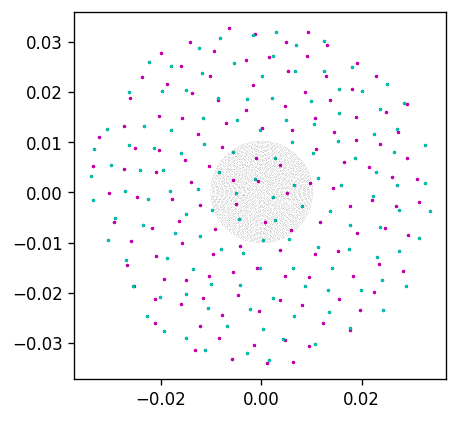

In [13]:
fig = plt.figure(figsize = (4,4), dpi = 120)
ax = fig.add_subplot(111)
parvo_mc = ['or', 'om', 'og', 'oc']
for i in range(4):
    pick = RG_OnOff == i
    ax.plot(parvo_cart[0,pick], parvo_cart[1,pick], parvo_mc[i], ms = 1)
ax.plot(vpos[0,:], vpos[1,:], ',k', alpha = 0.1)
ax.set_aspect('equal')

In [14]:
def assign_disk_xyID(n, pos, ratio = 2):
    xyID = np.zeros((2,n), dtype = 'i4')
    w = int(np.ceil(np.sqrt(n*4/np.pi)))
    xy = np.zeros((2,w*w), dtype = 'i4')
    xy[0,:] = np.tile(np.arange(w), w)
    xy[1,:] = np.repeat(np.arange(w), w)
    nonreplace_pick = np.ones(w*w, dtype = bool)
    pos_id = np.arange(w*w)
    pos = pos*w
    xy = xy.T
    max_dis = w
    for i in range(n):
        dis = np.max(np.abs(pos[:,i] - xy), axis = 1)
        local_pick = np.logical_and(dis <= max_dis, nonreplace_pick)
        if local_pick.sum() == 0:
            raise Exception(f'no free tile point within {max_dis}')
        local_dis = dis[local_pick]
        local_id = pos_id[local_pick]
        imin = np.argmin(local_dis)
        xyID[:,i] = xy[local_id[imin],:]
        if xyID[0,i] == 0 and xyID[1,i] == 0:
            print(f'{i}:{xyID[:,i]}')
        if xyID[0,i] == 0 and xyID[1,i] == 1:
            print(f'{i}:{xyID[:,i]}')
        if xyID[0,i] == 1 and xyID[1,i] == 0:
            print(f'{i}:{xyID[:,i]}')
        if xyID[0,i] == 1 and xyID[1,i] == 1:
            print(f'{i}:{xyID[:,i]}')
        nonreplace_pick[local_id[imin]] = False 
        stdout.write(f'\r {i/n*100:.1f}%')
    assert(np.logical_not(nonreplace_pick).sum() == n)
    assert(nonreplace_pick.sum() == w*w - n)
    stdout.write('\n')
    return xyID, w

xyID, w = assign_disk_xyID(nparvo, (parvo_cart + LGN_ecc)/(2*LGN_ecc))

 99.8%


26


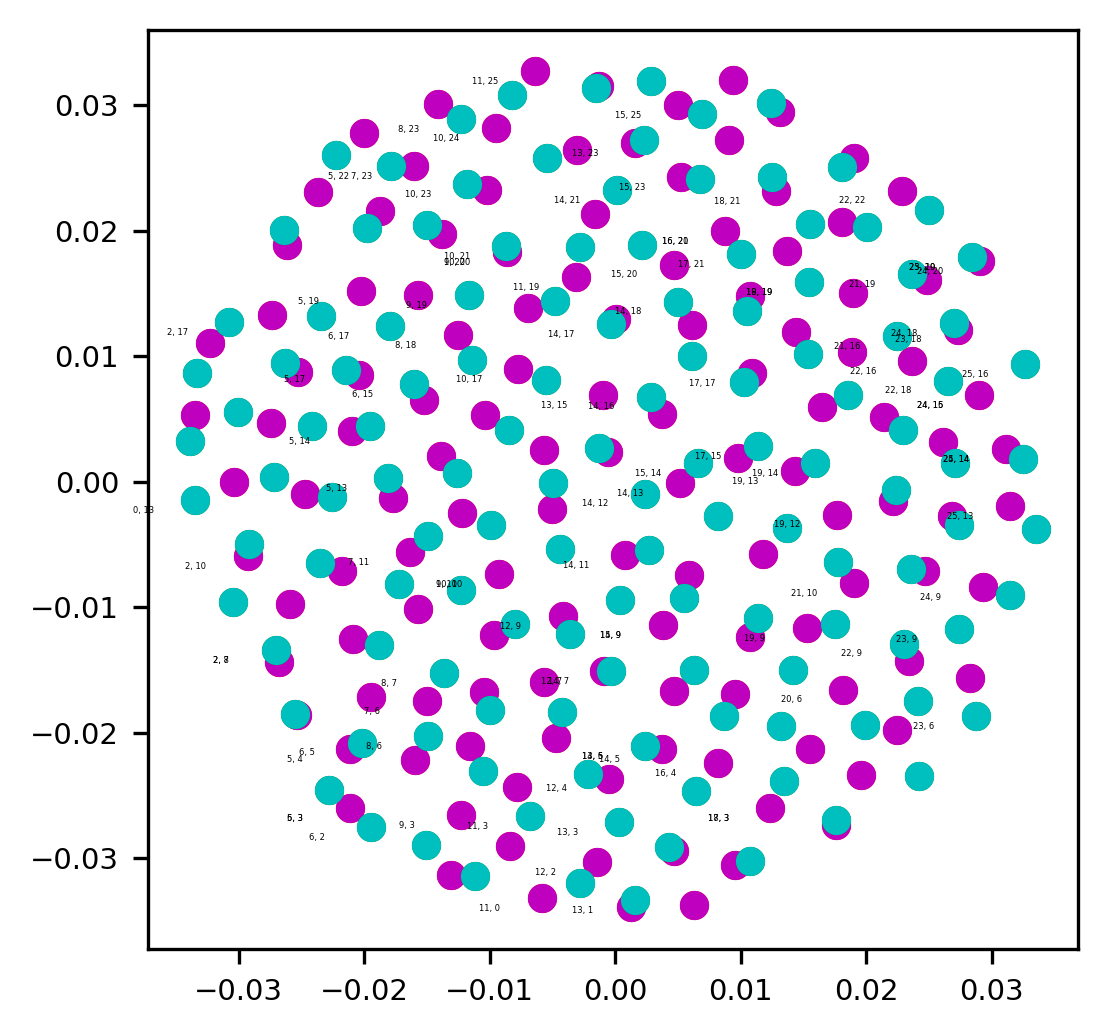

In [15]:
fig = plt.figure(figsize = (4,4), dpi = 300)
ax = fig.add_subplot(111)
parvo_mc = ['or', 'om', 'og', 'oc']
for i in range(4):
    pick = RG_OnOff == i
    ax.plot(parvo_cart[0,pick], parvo_cart[1,pick], parvo_mc[i])
        
check_list = np.random.permutation(np.arange(nparvo))
nsample = 100
for i in range(nsample):
    j = check_list[i]
    ax.text(parvo_cart[0,j]-0.005, parvo_cart[1,j]-0.001, f'{xyID[0,j]}, {xyID[1,j]}', fontsize = 2)

ax.set_aspect('equal')
ax.tick_params(axis = 'x', labelsize = 7)
ax.tick_params(axis = 'y', labelsize = 7)
print(w)

In [16]:
LGN_surfaceID_file = fdr + 'LGN_surfaceID' + theme + '.bin'
with open(LGN_surfaceID_file, 'wb') as f:
    np.array([w, w]).astype('u4').tofile(f)
    xyID.tofile(f)

In [17]:
def cart2polar(x, y):
    theta = np.arctan2(y, x)
    r = np.sqrt(x*x + y*y)
    return theta, r
parvo_polar = np.empty(parvo_cart.shape)
parvo_polar[0,:], parvo_polar[1,:] = cart2polar(parvo_cart[0,:], parvo_cart[1,:])

In [18]:
LGN_vpos_file = fdr + 'LGN_vpos' + theme + '.bin'
fp = 'f4'
with open(LGN_vpos_file, 'wb') as f:
    #       #type,  # ipsi-     | # contra-
    np.array([nparvo, 0], dtype = 'u4').tofile(f)
    np.array([ecc], dtype = fp).tofile(f)
    # cart
    #         xmin, xmax, ymin, ymax
    np.array([-LGN_ecc, 2*LGN_ecc, -LGN_ecc, 2*LGN_ecc], dtype = fp).tofile(f)
    parvo_cart.astype(fp).tofile(f)
    # type
    RG_OnOff.astype('u4').tofile(f)
    # polar
    parvo_polar.astype(fp).tofile(f)